# Visão Geral da Etapa 2

> **Meta principal:** construir um GAN simples (1 hidden layer com 10 neurônios) para gerar vetores RSSI realistas a partir dos 1000 vetores reais já simulados.

---

## Estrutura esperada

* `X_real`: matriz 1000 × 10 (RSSI dos 10 APs) extraída de `df_simulated`
* `Generator`: entrada = vetor ruído (tamanho 10), saída = vetor RSSI com 10 valores
* `Discriminator`: entrada = vetor RSSI com 10 valores, saída = probabilidade real/fake

---

## Etapa 2A — Implementação do GAN

Aqui está a implementação completa inicial (sem ainda salvar os modelos ou plotar):


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential, Input
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [11]:
path_file = '/home/darkcover/Documentos/Gan/Data/ujindoorsubset_building1_floor2.csv'
df_simulated = pd.read_csv(path_file)

In [13]:
# ================================
# Dados reais de entrada
# ================================
X_real = df_simulated.iloc[:, :10].values.astype(np.float32)  # Apenas WAP001–WAP010
n_features = X_real.shape[1]
latent_dim = n_features  # 10

# ================================
# Gerador
# ================================
def build_generator():
    model = Sequential([
        Input(shape=(latent_dim,)),
        layers.Dense(10, activation='relu'),
        layers.Dense(n_features, activation='tanh')  # saída entre -1 e 1
    ])
    return model


# ================================
# Discriminador
# ================================
def build_discriminator():
    model = Sequential([
        Input(shape=(n_features,)),
        layers.Dense(10, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# ================================
# Compilação do Discriminador
# ================================
generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))

# ================================
# Modelo GAN
# ================================
discriminator.trainable = False
gan_input = Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = tf.keras.Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))




---

## Etapa 2B — Loop de Treinamento (200 épocas)

Abaixo está o **código completo do treino**, com:

* Treinamento separado do **Discriminador**
* Atualização do **Generator via GAN**
* Armazenamento das perdas por época
* Gráfico de evolução das perdas

---

###  Implementação do Loop de Treinamento


In [14]:
# ================================
# Loop de Treinamento do GAN
# ================================
epochs = 200
batch_size = 64
half_batch = batch_size // 2

# Armazenar perdas
d_losses = []
g_losses = []

for epoch in range(epochs):
    # === 1. Treinar Discriminador ===
    # Amostras reais
    idx = np.random.randint(0, X_real.shape[0], half_batch)
    real_samples = X_real[idx]
    real_labels = np.ones((half_batch, 1))

    # Amostras falsas
    noise = np.random.uniform(-1, 1, (half_batch, latent_dim))
    fake_samples = generator.predict(noise, verbose=0)
    fake_labels = np.zeros((half_batch, 1))

    # Treinar o discriminador
    d_loss_real = discriminator.train_on_batch(real_samples, real_labels)
    d_loss_fake = discriminator.train_on_batch(fake_samples, fake_labels)
    d_loss = 0.5 * (d_loss_real + d_loss_fake)

    # === 2. Treinar Generator ===
    noise = np.random.uniform(-1, 1, (batch_size, latent_dim))
    valid_y = np.ones((batch_size, 1))  # Generator quer que D acredite que é real
    g_loss = gan.train_on_batch(noise, valid_y)

    # === 3. Registrar perdas
    d_losses.append(d_loss)
    g_losses.append(g_loss)

    # === 4. Exibir progresso
    if (epoch + 1) % 20 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs} | D_loss: {d_loss:.4f} | G_loss: {g_loss:.4f}")

/home/darkcover/.cache/pypoetry/virtualenvs/gan-oPyfrVEv-py3.12/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 1/200 | D_loss: 16.9547 | G_loss: 0.6777
Epoch 20/200 | D_loss: 12.2208 | G_loss: 0.4292
Epoch 40/200 | D_loss: 12.4146 | G_loss: 0.2759
Epoch 60/200 | D_loss: 12.6099 | G_loss: 0.2045
Epoch 80/200 | D_loss: 12.7248 | G_loss: 0.1664
Epoch 100/200 | D_loss: 12.7901 | G_loss: 0.1429
Epoch 120/200 | D_loss: 12.8334 | G_loss: 0.1271
Epoch 140/200 | D_loss: 12.8627 | G_loss: 0.1156
Epoch 160/200 | D_loss: 12.8928 | G_loss: 0.1070
Epoch 180/200 | D_loss: 12.9180 | G_loss: 0.1002
Epoch 200/200 | D_loss: 12.9381 | G_loss: 0.0948


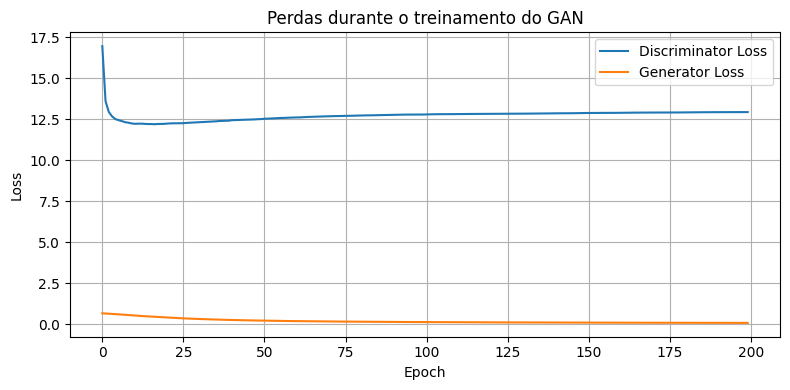

In [15]:

#=====Plotar gráfico de perdas=====
# Gráfico de perda
plt.figure(figsize=(8, 4))
plt.plot(d_losses, label="Discriminator Loss")
plt.plot(g_losses, label="Generator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Perdas durante o treinamento do GAN")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



---

## Geração dos 40.000 vetores RSSI sintéticos

Este passo inclui:

1. **Gerar os vetores usando o Generator**
2. **Converter para DataFrame com colunas WAP001–WAP010**
3. **Aplicar truncamento se necessário** (valores devem estar entre -110 e -40)
4. **Salvar em CSV**
5. **Visualizar graficamente a dispersão dos dados gerados versus reais**

---

## Código completo da geração + visualização


In [16]:
# ================================
# 1. Gerar vetores sintéticos
# ================================
n_generated = 40000
latent_dim = 10
noise = np.random.uniform(-1, 1, size=(n_generated, latent_dim))
generated_rssi = generator.predict(noise, verbose=1)

# Aplicar limite de RSSI típico
generated_rssi = np.clip(generated_rssi, -110, -40)

# ================================
# 2. Criar DataFrame
# ================================
columns = [f'WAP{str(i+1).zfill(3)}' for i in range(generated_rssi.shape[1])]
df_generated = pd.DataFrame(generated_rssi, columns=columns)
df_generated["source"] = "generated"

# ================================
# 3. Salvar
# ================================
df_generated.to_csv("/home/darkcover/Documentos/Gan/Data/df_generated.csv", index=False)
print("✅ 40.000 vetores sintéticos salvos em: data/df_generated.csv")


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
✅ 40.000 vetores sintéticos salvos em: data/df_generated.csv


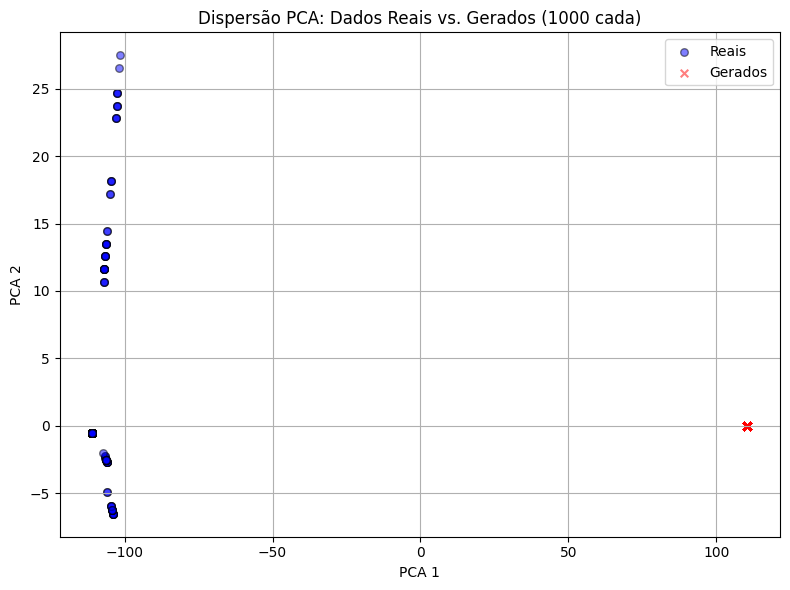

In [17]:

## Dispersão visual (reais vs. gerados)

# Pegar amostras reais para comparar visualmente
df_real_sample = df_simulated.sample(1000, random_state=42).copy()
df_real_sample["source"] = "real"

# Combinar para visualização
df_vis = pd.concat([df_real_sample, df_generated.sample(1000, random_state=42)], ignore_index=True)

# PCA para reduzir de 10 → 2 dimensões
from sklearn.decomposition import PCA

X_vis = df_vis.iloc[:, :10].values
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_vis)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[df_vis["source"] == "real", 0], X_pca[df_vis["source"] == "real", 1],
            alpha=0.5, label="Reais", c="blue", edgecolors='black', s=30)
plt.scatter(X_pca[df_vis["source"] == "generated", 0], X_pca[df_vis["source"] == "generated", 1],
            alpha=0.5, label="Gerados", c="red", marker='x', s=30)

plt.title("Dispersão PCA: Dados Reais vs. Gerados (1000 cada)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


---

* Arquivo `df_generated.csv` com 40.000 vetores prontos
* Visualização clara da **coerência dos dados gerados**
* Fim da **Etapa 2** com todos os entregáveis completos
